In [1]:
import os, sys, glob
os.environ['R_HOME'] = sys.exec_prefix + '/lib/R/'
import numpy as np
import scanpy as sc
import scFates as scf

In [2]:
geo = 'GSE162534'
fn = glob.glob(os.path.join('..', '*', '*', '*', f'{geo}_adata_processed.h5ad'))[0]
adata = sc.read_h5ad(fn)

In [3]:
adata

AnnData object with n_obs × n_vars = 8725 × 19013
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'celltype'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'm', 'v', 'n_obs', 'res', 'lp', 'lpa', 'qv', 'highly_variable'
    uns: 'celltype_colors', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

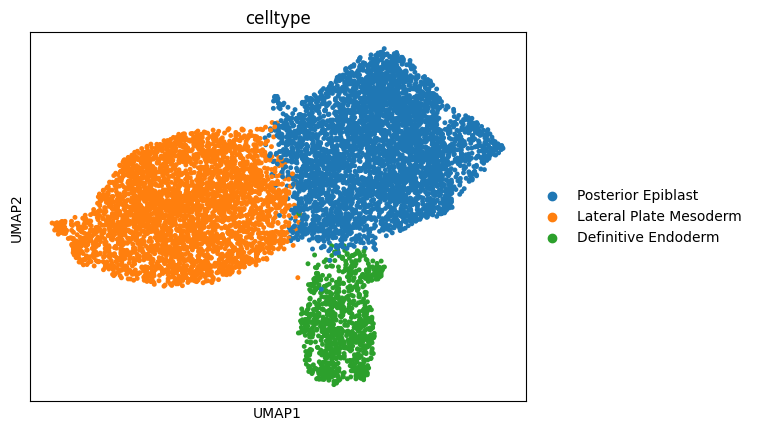

In [4]:
sc.pl.umap(adata, color = 'celltype', size = 50)

In [5]:
adata = adata[(adata.obs.celltype != 'Definitive Endoderm')]

In [6]:
adata

View of AnnData object with n_obs × n_vars = 7817 × 19013
    obs: 'sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'celltype'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'm', 'v', 'n_obs', 'res', 'lp', 'lpa', 'qv', 'highly_variable'
    uns: 'celltype_colors', 'leiden', 'log1p', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

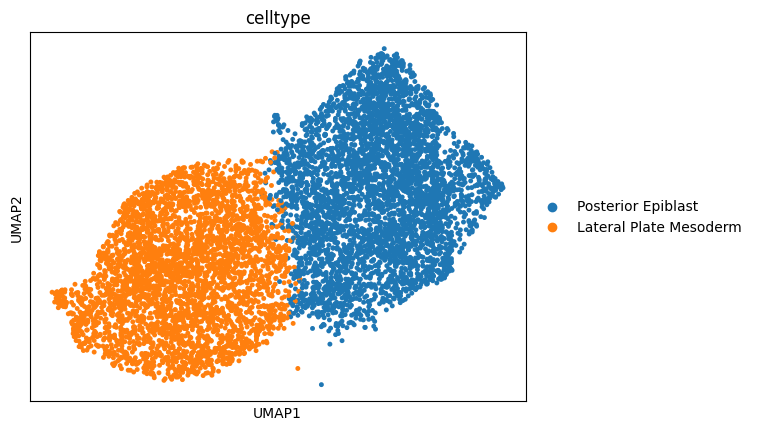

In [7]:
sc.pl.umap(adata, color = 'celltype', size = 50)

inferring a principal curve --> parameters used 
    15 principal points, mu = 100, lambda = 0.01


/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/scFates/tools/graph_fitting.py:565: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["graph"] = graph


    finished (0:00:02) --> added 
    .uns['epg'] dictionnary containing inferred elastic curve generated from elpigraph.
    .obsm['X_R'] soft assignment of cells to principal points.
    .uns['graph']['B'] adjacency matrix of the principal points.
    .uns['graph']['F'], coordinates of principal points in representation space.


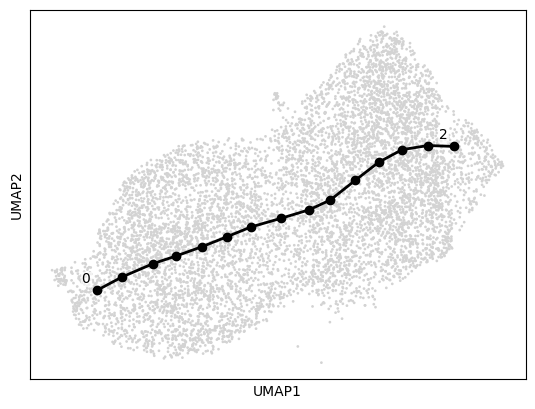

In [8]:
scf.tl.curve(adata, Nodes = 15, epg_lambda = .01, epg_mu = 100, use_rep = 'X_umap', plot = True, basis = 'umap')

In [9]:
scf.tl.root(adata, 2)

node 2 selected as a root --> added
    .uns['graph']['root'] selected root.
    .uns['graph']['pp_info'] for each PP, its distance vs root and segment assignment.
    .uns['graph']['pp_seg'] segments network information.


In [10]:
scf.tl.pseudotime(adata)

projecting cells onto the principal graph
    finished (0:00:01) --> added
    .obs['edge'] assigned edge.
    .obs['t'] pseudotime value.
    .obs['seg'] segment of the tree assigned.
    .obs['milestones'] milestone assigned.
    .uns['pseudotime_list'] list of cell projection from all mappings.


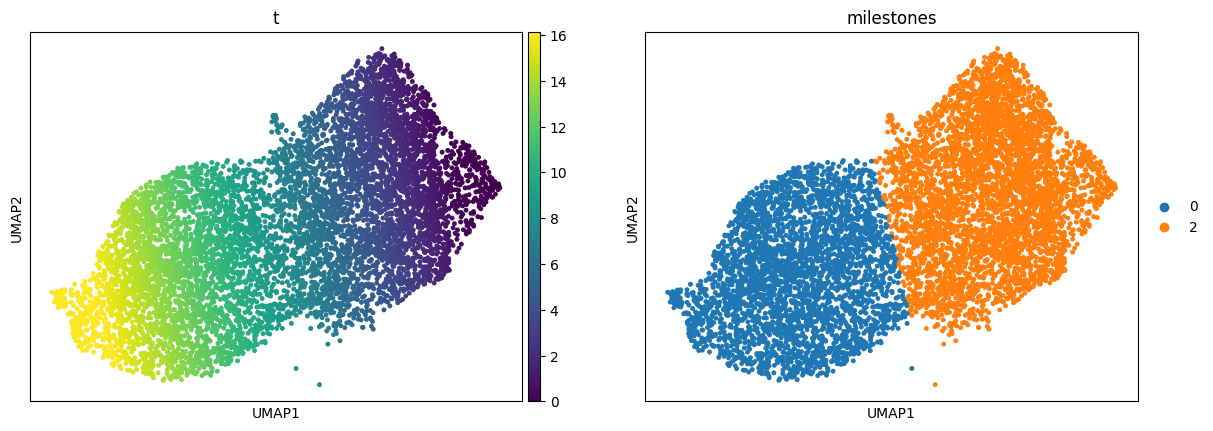

In [11]:
sc.pl.umap(adata, color = ['t', 'milestones'], size = 50)

/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


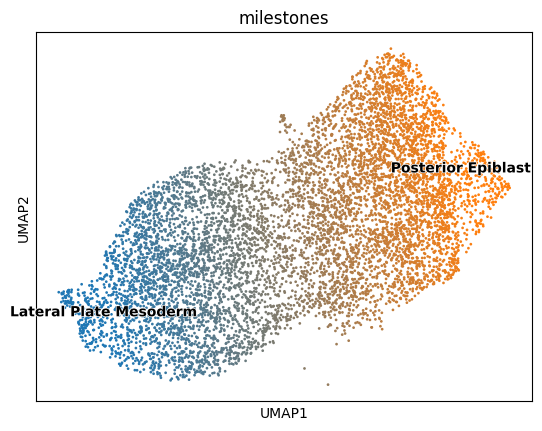

In [12]:
scf.tl.rename_milestones(adata, new = {'0' : 'Lateral Plate Mesoderm', '2' : 'Posterior Epiblast'})
scf.pl.milestones(adata, basis = 'umap', annotate = True)

In [13]:
scf.tl.test_association(adata, n_jobs = 8)

test features for association with the trajectory
    single mapping : 100%|██████████| 19013/19013 [19:38<00:00, 16.14it/s]
    found 219 significant features (0:19:41) --> added
    .var['p_val'] values from statistical test.
    .var['fdr'] corrected values from multiple testing.
    .var['st'] proportion of mapping in which feature is significant.
    .var['A'] amplitue of change of tested feature.
    .var['signi'] feature is significantly changing along pseudotime.
    .uns['stat_assoc_list'] list of fitted features on the graph for all mappings.


In [14]:
scf.tl.fit(adata, n_jobs = 8)

fit features associated with the trajectory
    single mapping : 100%|██████████| 219/219 [00:26<00:00,  8.17it/s]
    finished (adata subsetted to keep only fitted features!) (0:00:28) --> added
    .layers['fitted'], fitted features on the trajectory for all mappings.
    .raw, unfiltered data.


Clustering features using fitted layer


/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/caleb/miniconda3/envs/scFates/lib/python3.11/site-packages/scFates/tools/cluster.py:116: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_s, resolution=resolution)


    finished (0:00:07) --> added 
    .var['clusters'] identified modules.


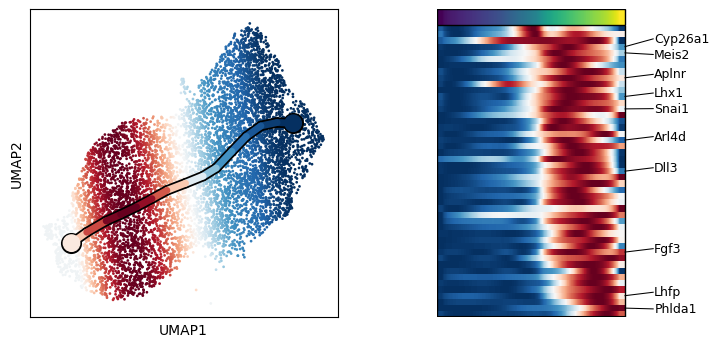

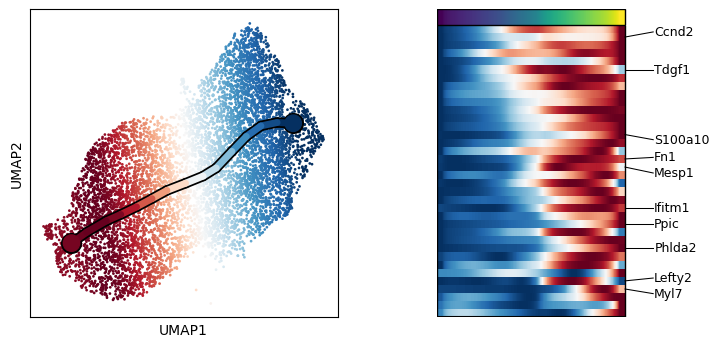

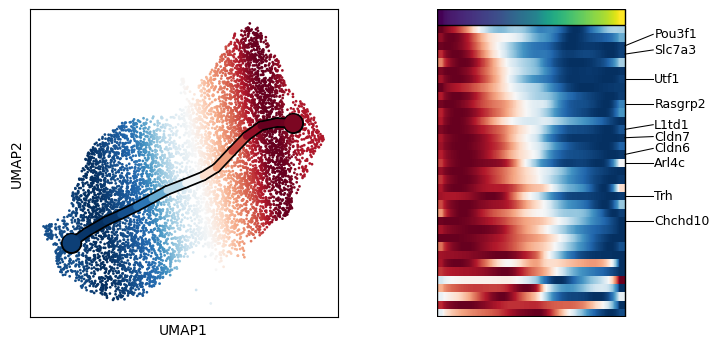

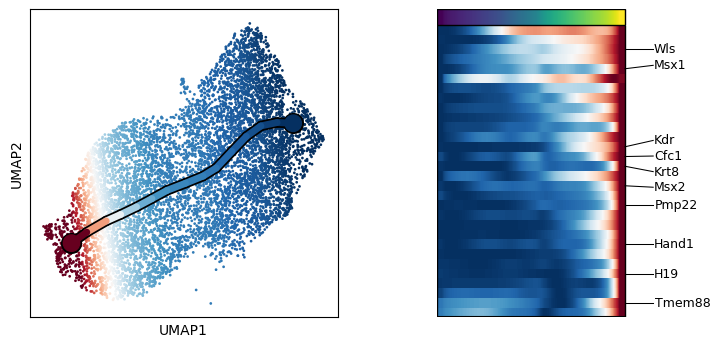

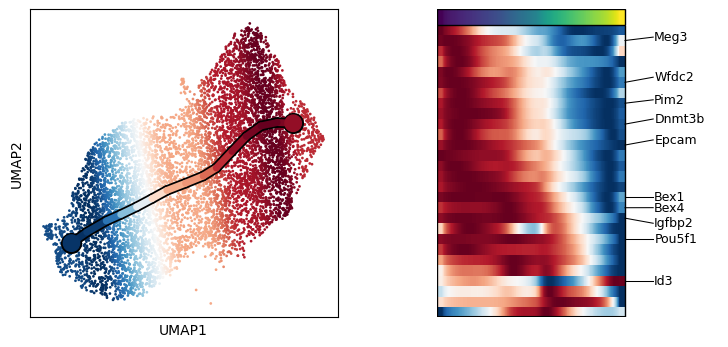

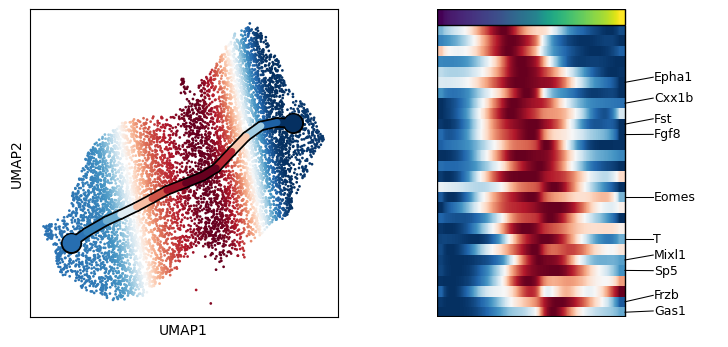

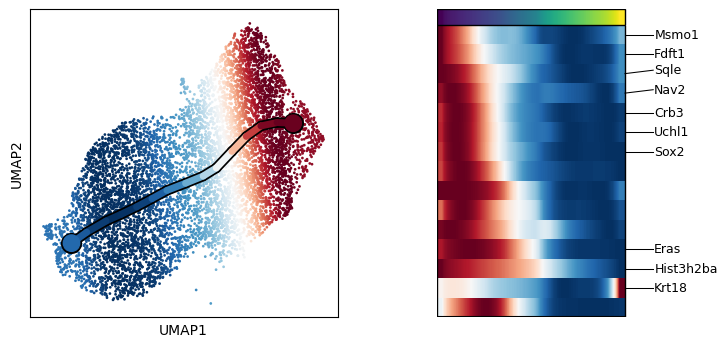

In [15]:
scf.tl.cluster(adata)
for clus in sorted(adata.var.clusters.unique()):
    clus_features = adata.var_names[adata.var.clusters == clus]
    scf.pl.trends(adata, features = clus_features, basis = 'umap')

In [16]:
del adata.uns['epg']

In [17]:
outdir = os.path.join('..', 'data', 'trajectories', geo)
os.mkdir(outdir)
adata.write(os.path.join(outdir, f'{geo}_adata_trajectory.h5ad'))

In [18]:
signature_outdir = os.path.join('results', geo)
os.mkdir(signature_outdir)
np.savetxt(os.path.join(signature_outdir, f'{geo}.txt'), adata.var_names, fmt = '%s')